In [46]:
# added this to get tab-complete working on theta
%config Completer.use_jedi = False
import os,sys,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp

In [210]:
base_path = '/lus/theta-fs0/logs/pythonlogging/module_usage/'
check_for_modules = ['tensorflow','torch','horovod','pandas','matplotlib','h5py','sklearn','numpy','scipy','balsam']

In [233]:
def commonize_source(source):
    try:
        if source.startswith('/soft/'):
            source = source.replace('/soft/','/lus/theta-fs0/software/')
        elif source.startswith('/projects/'):
            source = source.replace('/projects/','/lus/theta-fs0/projects/')
        elif source.startswith('/home/'):
            source = source.replace('/home/','/gpfs/mira-home/')
        
        if source.endswith('python3.8'):
            source = source.replace('python3.8','python')
        elif source.endswith('python3.7'):
            source = source.replace('python3.7','python')
        elif source.endswith('python3'):
            source = source.replace('python3','python')
        return source
    except:
        return ''

def parse_datafile(filename):
    try:
        data = json.load(open(filename))
    except:
        print(f'failed to parse filename: {filename}')
        return {}
    #print(json.dumps(data,indent=4, sort_keys=True))

    output_data = {}
    output_data['hostname'] = data['hostname']
    output_data['hpcname'] = 'NA'
    output_data['thetaknl'] = 0
    if 'nid' in data['hostname']:
        output_data['thetaknl'] = 1
    output_data['thetagpu'] = 0
    if 'thetagpu' in data['hostname']:
        output_data['thetagpu'] = 1
    output_data['cooley'] = 0
    if 'cooley' in data['hostname']:
        output_data['cooley'] = 1
    output_data['filename'] = filename
    output_data['source'] = commonize_source(data['sys.executable'])
    output_data['timestamp'] = pd.Timestamp(data['timestamp'])
    modules = []
    for module in data['modules'].keys():
        module = module.split('.')[0]
        if module not in modules:
            modules.append(module)

    for key in check_for_modules:
        output_data[key] = 0
        if key in modules:
            output_data[key] = 1
    
    return output_data


def get_file_list(path,years=[],months=[],days=[]):
    filelist = []
    for root, dirs, files in os.walk(path):
        
        rr = root.replace(path,'')
        rr = rr.split('/')
        if len(rr) == 3:
            year = int(rr[0])
            month = int(rr[1])
            day = int(rr[2])
            if(((len(years) > 0 and year in years) or len(years) == 0) and 
               ((len(months) > 0 and month in months) or len(months) == 0) and
               ((len(days) > 0 and day in days) or len(days) == 0)):
                print(year,month,day)
                print(root,len(dirs),len(files))
                for file in files:
                    
                    filename = os.path.join(root,file)
                    if os.stat(filename).st_size == 0:
                        continue
                    
                    filelist.append(filename)
    return filelist

dataset = pd.DataFrame()
def append(output):
    global dataset
    if len(output) > 0:
        dataset = dataset.append(output,ignore_index=True)

gsource_map = {}
def get_source_id(dataset):
    global gsource_map
    unique_source = list(set(dataset['source'].to_list()))
    gsource_map = { unique_source[i]:i for i in range(len(unique_source))}
    return dataset['source'].replace(gsource_map)

def build_dataset(path,nprocs,years=[],months=[],days=[]):
    global dataset
    dataset = pd.DataFrame()
    filelist = get_file_list(path,years,months,days)
    print(f'{len(filelist)} files')
    with mp.Pool(processes=nprocs) as pool:
        r = pool.map_async(parse_datafile,filelist,callback=append)
        r.wait()
    dataset['source_id'] = get_source_id(dataset)
    return dataset


In [234]:
ds = build_dataset(base_path,128,years=[2020],months=[11],days=[])

2020 11 20
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/20 0 77
2020 11 28
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/28 0 142
2020 11 29
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/29 0 269
2020 11 23
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/23 0 409
2020 11 25
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/25 0 539
2020 11 30
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/30 0 10550
2020 11 21
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/21 0 119
2020 11 26
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/26 0 993
2020 11 24
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/24 0 149
2020 11 22
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/22 0 162
2020 11 27
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/11/27 0 111
13520 files


In [235]:
ds.to_csv('pysnooper_dataset_nov.csv')

In [238]:
def plot_tf_vs_pt(dataset):
    fig,ax = plt.subplots(1,figsize=(12,8),dpi=80)
    tf = dataset[dataset['tensorflow'] == 1]
    if len(dataset[dataset['tensorflow'] == 1]) > 0:
        dataset['timestamp'].groupby(dataset[dataset['tensorflow'] == 1]['timestamp'].dt.day).count().plot(kind='bar',ax=ax,label='tensorflow',color='orange')
    if len(dataset[dataset['torch'] == 1]) > 0:
        dataset['timestamp'].groupby(dataset[dataset['torch'] == 1]['timestamp'].dt.day).count().plot(kind='bar',ax=ax,label='torch',color='red')
    if len(dataset[dataset['balsam'] == 1]) > 0:
        dataset['timestamp'].groupby(dataset[dataset['balsam'] == 1]['timestamp'].dt.day).count().plot(kind='bar',ax=ax,label='balsam',color='green')
    ax.set_xlabel('day')
    ax.legend()
    ax.set_xlim(1,31)
    days = [ x for x in range(1,32) ]
    ax.set_xticks(days)
    ax.set_xticklabels(days)
    min_date = dataset['timestamp'].min()
    max_date = dataset['timestamp'].max()
    ax.set_title('Covers ' + str(min_date.date()) + ' to ' + str(max_date.date()))

def plot_source(dataset):
    fig,ax = plt.subplots(1,figsize=(12,8),dpi=80)
    dataset.groupby(dataset['source_id'])['timestamp'].count().plot(kind='bar',ax=ax,logy=True)
    ax.set_xlabel('python source module ID')
    min_date = dataset['timestamp'].min()
    max_date = dataset['timestamp'].max()
    ax.set_title('Covers ' + str(min_date.date()) + ' to ' + str(max_date.date()))
    

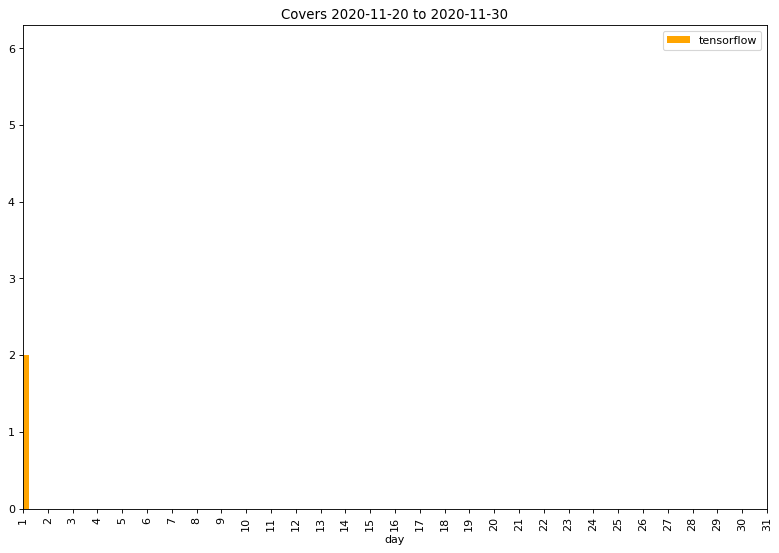

In [239]:
plot_tf_vs_pt(ds)

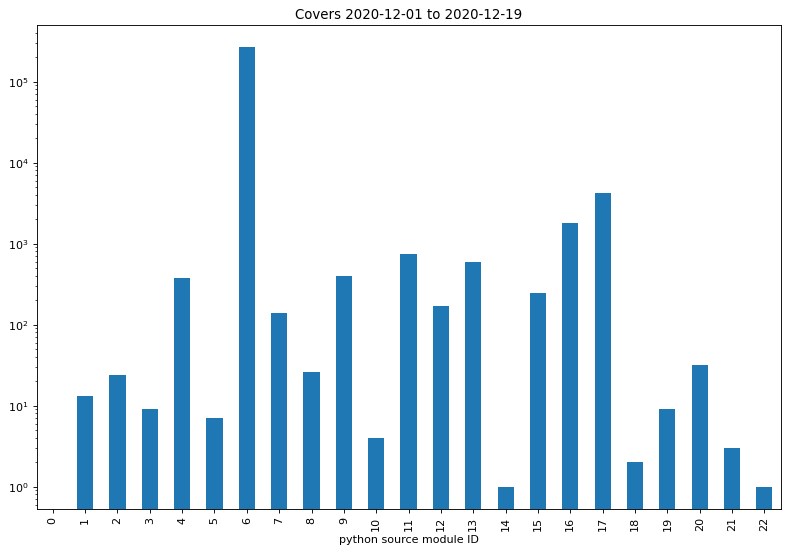

In [209]:
plot_source(ds)

In [192]:
gsource_map

{nan: 0,
 '/gpfs/mira-home/zqiao/conda/ENV_pytorch/bin/python': 1,
 '/gpfs/mira-home/matitov/.miniconda3/bin/python': 2,
 '/lus/theta-fs0/projects/ExaLearn/Ganesh/software/GPyTorch_ENV/bin/python': 3,
 '/lus/theta-fs0/software/datascience/Deephyper/0.2.1/env/bin/python': 4,
 '/lus/theta-fs0/software/datascience/conda/miniconda3/2020-03/bin/python': 5,
 '/lus/theta-fs0/software/datascience/conda/miniconda3/latest/bin/python': 6,
 '/lus/theta-fs0/software/thetagpu/balsam/env2/bin/python': 7,
 '/lus/theta-fs0/software/thetagpu/conda/tf_master/2020-11/mconda3/bin/python': 8,
 '/lus/theta-fs0/software/thetagpu/conda/tf_master/2020-12-17/mconda3/bin/python': 9,
 '/lus/theta-fs0/projects/ExaLearn/Ganesh/software/THETAGPU_TF_ENV/bin/python': 10,
 '/lus/theta-fs0/software/datascience/conda/miniconda3/2020-12/bin/python': 11,
 '/gpfs/mira-home/fsimini/.conda/envs/tgpupt/bin/python': 12,
 '/gpfs/mira-home/matitov/rct_gpu/bin/python': 13,
 '/gpfs/mira-home/fsimini/.conda/envs/aaa/bin/python': 14,


In [237]:
ds

,hostname,hpcname,thetaknl,thetagpu,cooley,filename,source,timestamp,tensorflow,torch,horovod,pandas,matplotlib,h5py,sklearn,numpy,scipy,balsam,source_id
0,thetalogin3,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-20 20:20:13.570337,0,0,0,0,0,0,0,0,0,0,2
1,thetalogin5,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-20 21:48:12.185563,0,0,0,0,0,0,0,0,0,0,2
2,thetamom2,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-20 20:27:46.700854,0,0,0,0,0,0,0,0,0,0,2
3,thetalogin5,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-20 22:07:22.655667,0,0,0,0,0,0,0,0,0,0,2
4,thetalogin4,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-20 22:27:31.962264,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13515,thetamom2,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-27 17:16:57.394162,0,0,0,0,0,0,0,0,0,0,2
13516,thetalogin3,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-27 18:19:39.354020,0,0,0,0,0,0,0,0,0,0,2
13517,thetalogin5,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-27 16:10:36.306927,0,0,0,0,0,0,0,0,0,0,2
13518,thetalogin3,NA,0,0,0,/lus/theta-fs0/logs/pythonlogging/module_usage...,/lus/theta-fs0/software/datascience/conda/mini...,2020-11-27 22:19:26.278156,0,0,0,0,0,0,0,0,0,0,2
